In [1]:
# In case you do not have numpy or qutip installed, you need to install it (of course, this is also true for qiskit)
!pip install numpy
!pip install qutip

In [2]:
# We will need some functionality 
from typing import List 

# and from math related libraries
import numpy as np
import qutip as qt

# and from qiskit
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Operator

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
from numbers import Number
import numpy

from qiskit.circuit import Gate, QuantumCircuit, QuantumRegister, ParameterExpression
from qiskit.quantum_info.operators.predicates import matrix_equal
from qiskit.quantum_info.operators.predicates import is_hermitian_matrix
from qiskit.extensions.exceptions import ExtensionError
from qiskit.circuit.exceptions import CircuitError

from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister 


from qiskit.extensions.unitary import UnitaryGate

# This code is based on https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/extensions/hamiltonian_gate.py licenced under Apache licence.
class CustomHamiltonianGate(Gate):
    def __init__(self, time, num_qubits, connectivity, h_coeff0,h_coeff1,h_coeff2,h_coeff3, label=None):
        if isinstance(time, Number) and time != numpy.real(time):
            raise ExtensionError("Evolution time is not real.")
       
        self.num_qubits = num_qubits
        self.connectivity = connectivity
        # Store instruction params
        super().__init__("custom_hamiltonian", num_qubits, [time, num_qubits, connectivity, h_coeff0,h_coeff1,h_coeff2,h_coeff3], label=label)

    def __array__(self, dtype=None):
        """Return matrix for the unitary."""
        # pylint: disable=unused-argument
        import scipy.linalg

        try:
            return scipy.linalg.expm(-1j * self.get_ham() * float(self.params[0]))
        except TypeError as ex:
            raise TypeError(
                "Unable to generate Unitary matrix for "
                "unbound t parameter {}".format(self.params[1])
            ) from ex

    def _define(self):
        """Calculate a subcircuit that implements this unitary."""
        q = QuantumRegister(self.num_qubits, "q")
        qc = QuantumCircuit(q, name=self.name)
        qc._append(UnitaryGate(self.to_matrix()), q[:], [])
        self.definition = qc

    def validate_parameter(self, parameter):
        return parameter

    def get_ham(self):
        dim = 2 ** self.num_qubits
        num_connections = len(self.connectivity)
        zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)

        for c in range(num_connections):
            ops_to_tensor = [qt.identity(2)] * num_qubits
            ops_to_tensor[self.connectivity[c][0]] = qt.sigmaz()
            ops_to_tensor[self.connectivity[c][1]] = qt.sigmaz()
            zz_hamiltonian += float(self.params[3+c]) * np.array(qt.tensor(ops_to_tensor)) #+= 

        return zz_hamiltonian

def custom_hamiltonian(self, time, connectivity, h_coeff0,h_coeff1,h_coeff2,h_coeff3, qubits, label=None):
    """Apply hamiltonian evolution to qubits."""
    if not isinstance(qubits, list):
        qubits = [qubits]

    return self.append(CustomHamiltonianGate(time=time, num_qubits =len(qubits), connectivity=connectivity, h_coeff0=h_coeff0,h_coeff1=h_coeff1,h_coeff2 = h_coeff2,h_coeff3 = h_coeff3, label=label), qubits, [])


QuantumCircuit.custom_hamiltonian = custom_hamiltonian


In [4]:
print(custom_hamiltonian)

<function custom_hamiltonian at 0x7f2dd8387430>


In [22]:
#parameterizing the Circuit

from qiskit.circuit import  ParameterVector
psi0 = ParameterVector('psi0', 4) # As we have 4 Qubits, so We have 4 Psi in the single analog block 
psi1 = ParameterVector('psi1', 4) # As we have 4 Qubits, so We have 4 Psi in the single analog block 
psi2 = ParameterVector('psi2', 4) # As we have 4 Qubits, so We have 4 Psi in the single analog block 





num_qubits = 4
qr = QuantumRegister(num_qubits)
circ3 = QuantumCircuit(qr)
# Building the Circuit
circ3.h(0)
circ3.h(1)
circ3.h(2)
circ3.h(3)
circ3.rz(np.pi/2,qr[1])
circ3.rz(np.pi/2,qr[2])
circ3.rz(np.pi/2,qr[3])
circ3.custom_hamiltonian(connectivity=[[0, 1],[1,2],[2,3]], h_coeff0=psi0[0], h_coeff1=psi0[1], h_coeff2=psi0[2] ,h_coeff3=psi0[3], time=1, qubits=[qr[0], qr[1], qr[2], qr[3]], label='analog block_1')
circ3.h(0)
circ3.h(1)
circ3.h(2)
circ3.h(3)
circ3.rz(np.pi/2,qr[1])
circ3.rz(np.pi/2,qr[2])
circ3.rz(np.pi/2,qr[3])
circ3.barrier()

circ3.custom_hamiltonian(connectivity=[[0, 1],[1,2],[2,3]], h_coeff0=psi1[0], h_coeff1=psi1[1], h_coeff2=psi1[2] ,h_coeff3=psi1[3], time=1, qubits=[qr[0], qr[1], qr[2], qr[3]], label='analog block_2')
circ3.h(0)
circ3.h(1)
circ3.h(2)
circ3.h(3)
circ3.rz(np.pi/2,qr[1])
circ3.rz(np.pi/2,qr[2])
circ3.rz(np.pi/2,qr[3])
circ3.barrier()
circ3.h(0)
circ3.h(1)
circ3.h(2)
circ3.h(3)
circ3.rz(np.pi/2,qr[1])
circ3.rz(np.pi/2,qr[2])
circ3.rz(np.pi/2,qr[3])
circ3.custom_hamiltonian(connectivity=[[0, 1],[1,2],[2,3]], h_coeff0=psi2[0], h_coeff1=psi2[1], h_coeff2=psi2[2] ,h_coeff3=psi2[3], time=1, qubits=[qr[0], qr[1], qr[2], qr[3]], label='analog block_3')
circ3.h(0)
circ3.h(1)
circ3.h(2)
circ3.h(3)
circ3.rz(np.pi/2,qr[1])
circ3.rz(np.pi/2,qr[2])
circ3.rz(np.pi/2,qr[3])


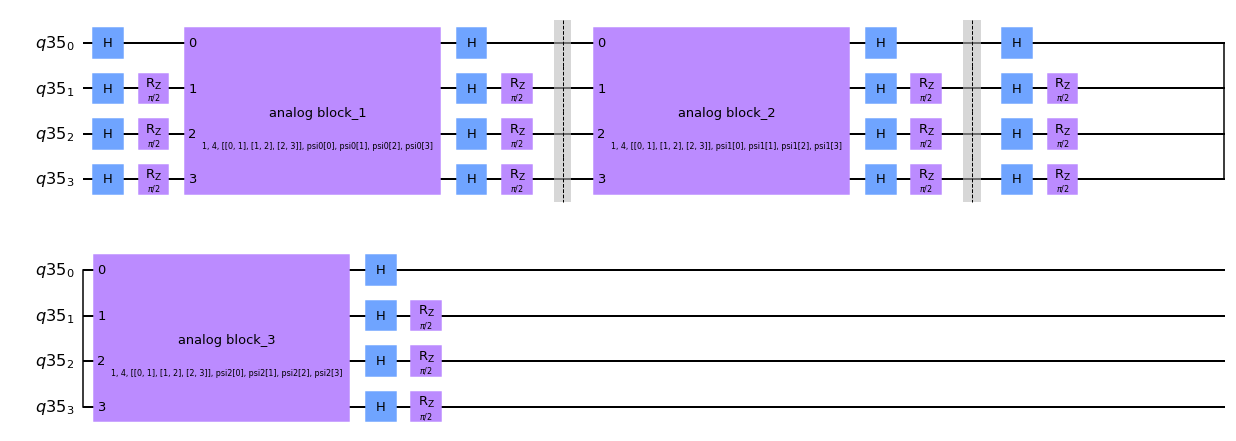

In [23]:
circ3.draw()

In [24]:
#Transpile the circuit
from qiskit.providers.aer import AerSimulator
from qiskit.compiler import transpile




bcirc3 = circ3.bind_parameters({psi0: [0, 0, 1, 1], psi1: [0, 0, 1, 1], psi2: [0, 0, 1, 1]} )

bcirc3.measure_all()

simulator = Aer.get_backend('aer_simulator') 
#bc3 = transpile(bc3, simulator) # added transpile step
job = execute(bcirc3, simulator, shots=1024, optimization_level=0)#, basis_gates=['ccx', 'cp', 'cswap', 'csx', 'cu', 'cu1', 'cu2', 'cu3', 'cx', 'cy', 'cz', 'delay', 'diagonal', 'h', 'id', 'initialize', 'mcp', 'mcphase', 'mcr', 'mcrx', 'mcry', 'mcrz', 'mcswap', 'mcsx', 'mcu', 'mcu1', 'mcu2', 'mcu3', 'mcx', 'mcx_gray', 'mcy', 'mcz', 'multiplexer', 'p', 'pauli', 'r', 'roerror', 'rx', 'rxx', 'ry', 'ryy', 'rz', 'rzx', 'rzz', 's', 'sdg', 'swap', 'sx', 'sxdg', 't', 'tdg', 'u', 'u1', 'u2', 'u3', 'unitary', 'x', 'y', 'z', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', "custom_hamiltonian"])
        

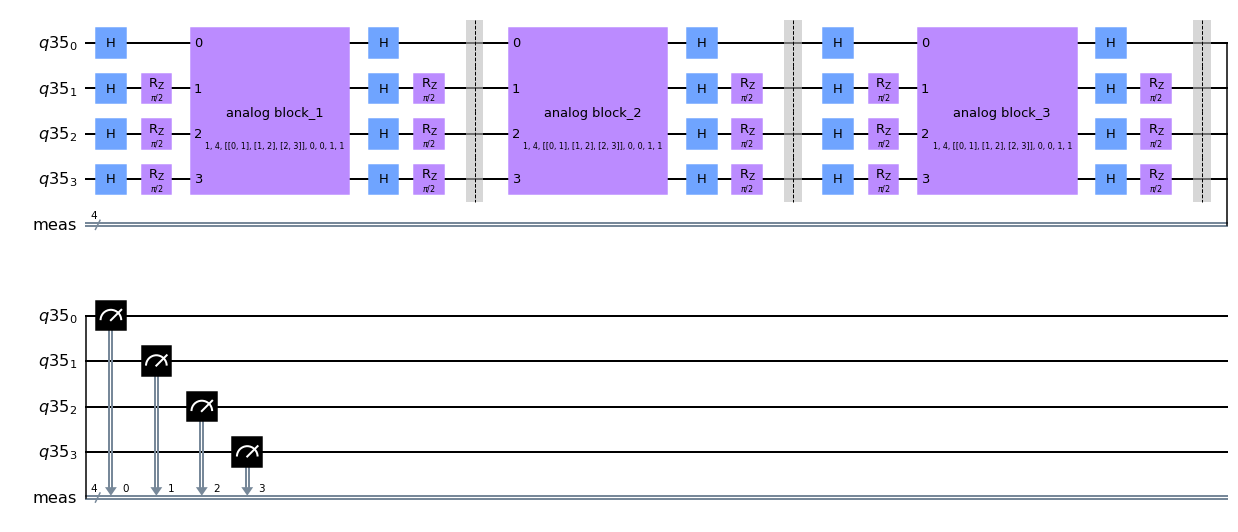

In [25]:
bcirc3.draw()

In [26]:
result = job.result()
counts = result.get_counts(bcirc3)
print(counts)

{'0001': 6, '1011': 10, '1001': 9, '1101': 19, '1110': 70, '0101': 8, '1100': 164, '0111': 10, '0011': 11, '0000': 169, '0010': 81, '1000': 147, '0110': 67, '0100': 180, '1111': 11, '1010': 62}


In [28]:
import numpy as np
import pylab

from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, NumPyEigensolver
from qiskit.algorithms.optimizers import SPSA, ADAM
from qiskit.opflow import I, X, Z
import numpy as np
import pylab

from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import I, X, Z


H2_op = (-1.052373245772859 * I ^ I ^ I ^I ) + \
        (0.39793742484318045 * I ^ Z ^ I ^I ) + \
        (-0.39793742484318045 * Z ^ I ^ I ^I ) + \
        (-0.01128010425623538 * Z ^ Z ^ I ^I ) + \
        (0.18093119978423156 * X ^ X ^ I ^I )
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')
seed = 500
iterations =125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

#ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
ansatz = circ3
#adam = ADAM()


spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

Reference value: -1.85728
VQE on Aer qasm simulator (no noise): -1.50990
Delta from reference energy value is 0.34737


Text(0.5, 1.0, 'Convergence with no noise')

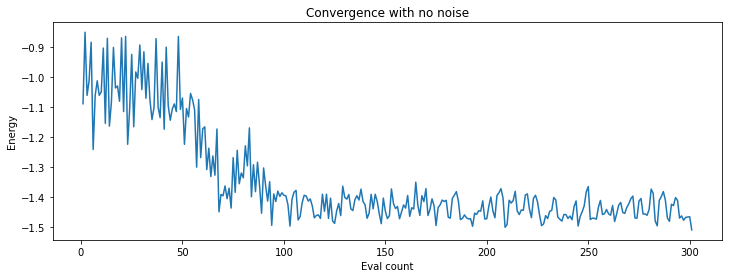

In [29]:
pylab.rcParams['figure.figsize'] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence with no noise')